In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import math
import json
from scipy.stats import gaussian_kde

import psycopg2 as psql
from psycopg2.extras import RealDictCursor
from statsmodels.nonparametric.kde import KDEUnivariate

import sys
sys.path.append("..")
from tools.flight_projection import *
from tools.flight_conflict_processor import filter_adsb_gaps
from tools.conflict_handling import gamma_angle, get_ac_distance_time, get_dx_dy, get_delta_dst, load_obj, get_delta_dst_t

import seaborn as sns
sns.set(color_codes=True)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

In [3]:
def sample_dst_kde(kde,hdg,dst_space,pct):
    
    gs = 50
    pdf = kde(np.array([[hdg]*gs,[v for v in dst_space]]))
    pdf_zip = list(zip(dst_space,np.cumsum(pdf)/max(np.cumsum(pdf))))
    
    pct_low = [(d,p) for (d,p) in pdf_zip if p <= 0.5-pct][-1][0]
    pct_high = [(d,p) for (d,p) in pdf_zip if p <= 0.5+pct][-1][0]
    
    return pct_low, pct_high

In [ ]:
cur_read_1 = conn.cursor(cursor_factory=RealDictCursor)
cur_read_1.execute("SELECT ts_1, ts_2, lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2 \
                FROM public.converging_flights limit 100;")
batch_1 = cur_read_1.fetchall()

cur_read_2 = conn.cursor(cursor_factory=RealDictCursor)
cur_read_2.execute("SELECT ts_1, ts_2, lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2 \
                FROM public.conflicts limit 500;")
batch_2 = cur_read_2.fetchall()

batch_1.extend(batch_2)
batch = batch_1

cur_read_1.close()
cur_read_2.close()

In [3]:
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT ts_1, ts_2, lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2 \
                FROM public.converging_flights limit 500;")
batch = cur_read.fetchall()

In [4]:
def generate_rand_from_pdf(pdf, x_grid):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(10000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

res_batch = []
bin_dict = {}
pdf_dict = {}

la_time = 1200

print('Preprocessing flights')

for b in batch:

    if len(b['ts_1']) != len(b['ts_2']):
        print('Flights do not have same lengths')
        continue

    f_df = pd.DataFrame.from_dict(b)
    if len(f_df) > 0:

        dstc_lst = []
        dst_lst = []

        for i, r in f_df.iterrows():
            dstc_lst.append(
                get_delta_dst(r['lat_1'], r['lon_1'], r['lat_2'], r['lon_2'],
                              r['hdg_1'], r['hdg_2'], r['spd_1'], r['spd_2']))

            dst_lst.append(calc_coord_dst((r['lat_1'], r['lon_1']),
                                          (r['lat_2'], r['lon_2'])))

        f_df['dst_change_i'] = dstc_lst
        f_df['dst'] = dst_lst

        f_df = f_df.dropna(how='any')
        f_df = f_df.reset_index(drop=True)

        if len(f_df) > 0:
            f_df['dst_change'] = [f_df['dst_change_i'].iloc[0]] * len(f_df)
            f_df['dst_diff'] = f_df['dst'].iloc[0] - f_df['dst']
            f_df['la_t'] = f_df['ts_1'] - f_df['ts_1'].iloc[0]
            
            delta_dst_t = []
            
            for i, rr in f_df.iterrows():
                delta_dst_t.append(get_delta_dst_t(rr['lat_1'], rr['lon_1'], rr['lat_2'], rr['lon_2'],
                                                   rr['hdg_1'], rr['hdg_2'], rr['spd_1'], rr['spd_2'], rr['la_t']))
                                   
            f_df['delta_dst_t'] = delta_dst_t
                                   
            f_df = f_df.dropna(how='any')
            f_df = f_df.reset_index(drop=True)
            
            if len(f_df) > 0:
                res_batch.append(f_df.to_dict(orient='list'))


# Create a dictionary for each look-ahead time bin with
# corresponding heading and distance difference values

Preprocessing flights


Creating value list


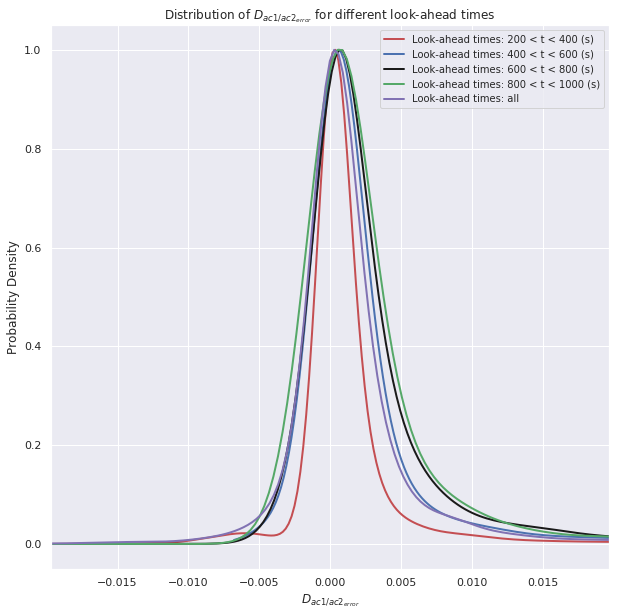

In [5]:
print('Creating value list')

def distr_func(_d, _dct, _t):
    return (_d - _dct) / (_dct * _t)

dd_data_raw = []
dd_data_raw_100 = []
dd_data_raw_400 = []
dd_data_raw_800 = []
dd_data_raw_1000 = []
dd_data_raw_x = []
ts_l = []

for f in res_batch:

    dstd_lst = f['dst_diff']
    dst_change = f['dst_change']
    ts_lst = f['la_t']
    delta_dst_t = f['delta_dst_t']

#     dd_data_raw.extend([d / (dc * t) for d, dc, t in
#                         zip(dstd_lst, dst_change, ts_lst) if dc*t != 0])
    
    dd_data_raw_100.extend([distr_func(d, dct, t) for d, dct, t in
                        zip(dstd_lst, delta_dst_t, ts_lst) if dct != 0 and 200 < t < 400])
    dd_data_raw_400.extend([distr_func(d, dct, t) for d, dct, t in
                        zip(dstd_lst, delta_dst_t, ts_lst) if dct != 0 and 400 < t < 600])
    dd_data_raw_800.extend([distr_func(d, dct, t) for d, dct, t in
                        zip(dstd_lst, delta_dst_t, ts_lst) if dct != 0 and 600 < t < 800])
    dd_data_raw_1000.extend([distr_func(d, dct, t) for d, dct, t in
                        zip(dstd_lst, delta_dst_t, ts_lst) if dct != 0 and 800 < t < 1000])
    
    dd_data_raw_x.extend([distr_func(d, dct, t) for d, dct, t in
                        zip(dstd_lst, delta_dst_t, ts_lst) if dct != 0])
    ts_l.extend([t for d, dct, t in
                        zip(dstd_lst, delta_dst_t, ts_lst) if dct != 0])

fig = plt.figure(figsize=(10,10))
cs = ['r','b','k','g','m']
label_set = ['Look-ahead times: 200 < t < 400 (s)', 'Look-ahead times: 400 < t < 600 (s)', 
          'Look-ahead times: 600 < t < 800 (s)', 'Look-ahead times: 800 < t < 1000 (s)', 'Look-ahead times: all']
flen = 20000
for i, dd_data_raw in enumerate([dd_data_raw_100[:flen], dd_data_raw_400[:flen], 
                                 dd_data_raw_800[:flen], dd_data_raw_1000[:flen], dd_data_raw_x[:flen]]):
#     dd_data_raw = 
    dd_data_p = np.percentile(dd_data_raw, 99.5)
    dd_data_filt = [v for v in dd_data_raw if abs(v) < dd_data_p]

    x_grid = np.linspace(min(dd_data_filt), max(dd_data_filt), 1000)
    kde = gaussian_kde(dd_data_filt)#, bw_method=0.1)
    kdepdf = kde.evaluate(x_grid)
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid)

    
#     plt.hist(dd_data_filt,density=False, bins=400)
    # plt.hist(random_from_kde, 500, normed=True, alpha=0.5, label='hist')
    plt.plot(x_grid, kdepdf/max(kdepdf), color=cs[i], linewidth=2, label=label_set[i])

# plt.xlim(-1,1)
dd_data_p80 = np.percentile(dd_data_raw, 97)
plt.xlim(-dd_data_p80, dd_data_p80)
plt.xlabel('$D_{ac1/ac2_{error}}$')
plt.ylabel('Probability Density')
plt.title("Distribution of $D_{ac1/ac2_{error}}$ for different look-ahead times")
plt.legend(loc='best', prop={'size': 10})
plt.show()

# Create final dictionary

pct_dict = {}
cdf_list = list(zip(x_grid, np.cumsum(kdepdf)/np.cumsum(kdepdf)[-1]))
for p in range(1, 100):
    pct_dict[str(p)] = [v[0] for v in cdf_list if v[1] <= p/100][-1]

(-100, 100)

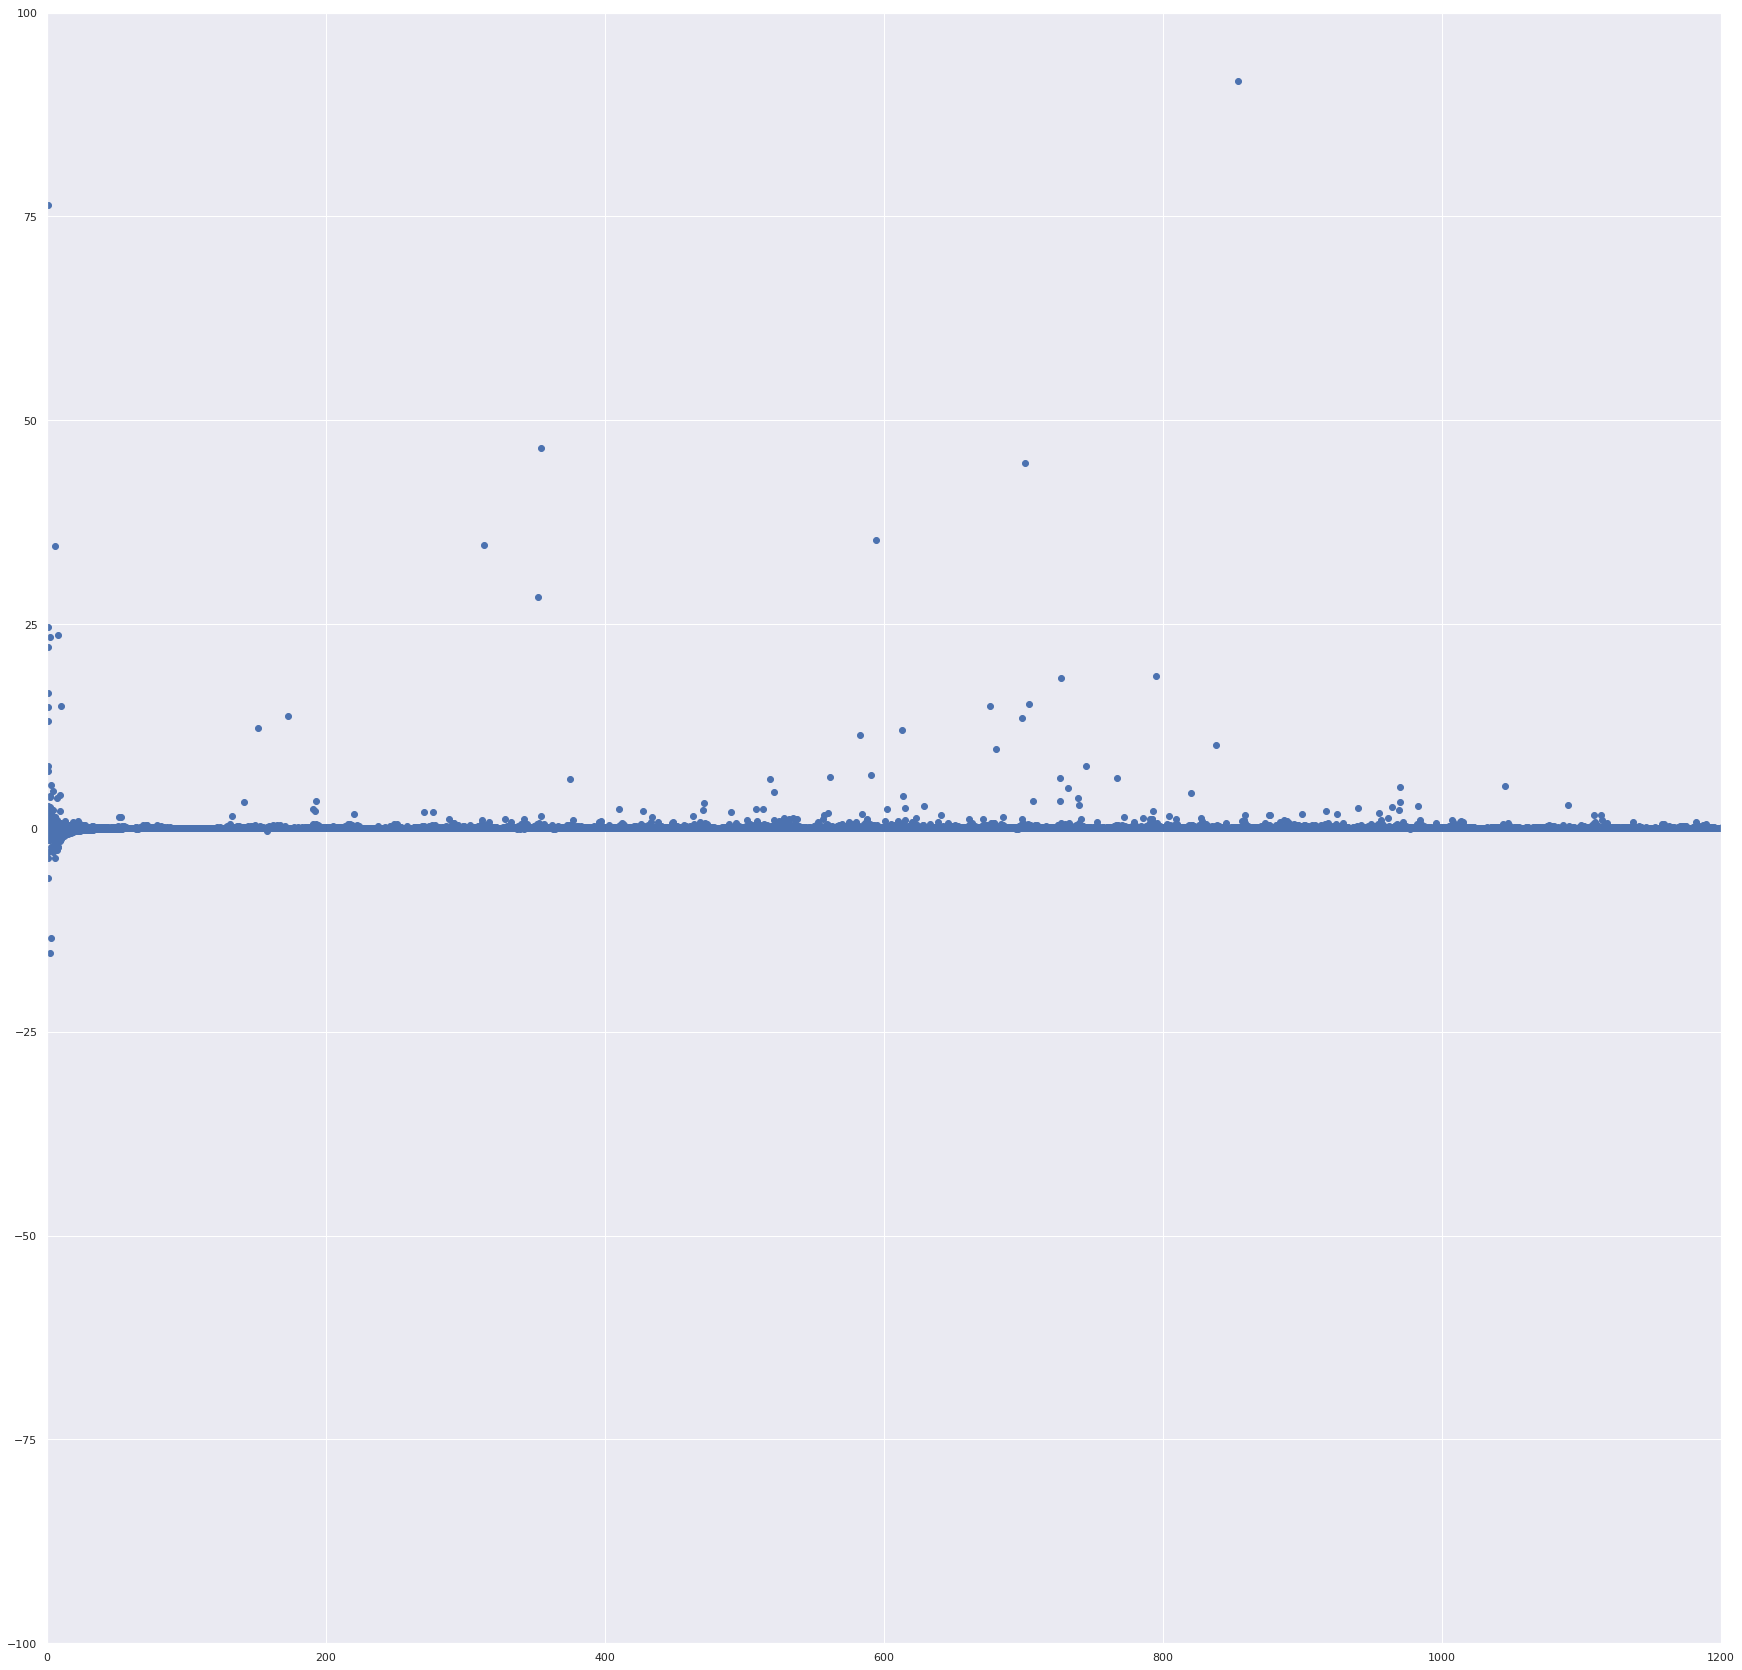

In [6]:
plt.figure(figsize=(30,30))
plt.scatter(ts_l, dd_data_raw_x)
plt.xlim(0,1200)
plt.ylim(-100,100)

In [ ]:


res_batch = []

for b in batch:
    
#     print(b.keys())
    filter_flag = 0

    if filter_flag == 1:
        ix = filter_adsb_gaps(b['ts_1'])
        if not ix:
            ix = (0, -1)
    else:
        ix = (0, -1)

    for k in b.keys():
        if '_1' in k:
            b[k] = b[k][ix[0]:ix[1]]
        if '_2' in k:
            b[k] = b[k][ix[0]:ix[1]]

    if len(b['ts_1']) != len(b['ts_2']):
        print('Flights do not have same lengths')
        continue

    f_df = pd.DataFrame.from_dict(b)
    if len(f_df) > 0:
        f_df['spd_diff'] = f_df['spd_1'] - f_df['spd_2']
        
#         f_df = f_df.drop_duplicates(['lat_1', 'lon_1'])
#         f_df = f_df.drop_duplicates(['lat_2', 'lon_2'])
#         f_df = f_df.reset_index(drop=True)

        dstc_lst = []
        hdg_diff_lst = []
        dst_lst = []

        for i,r in f_df.iterrows():
            dstc_lst.append(get_delta_dst(r['lat_1'], r['lon_1'],r['lat_2'],r['lon_2'],r['hdg_1'], r['hdg_2'], r['spd_1'], r['spd_2']))

            _g, _a, _b = gamma_angle(r['lat_1'], r['lon_1'],r['lat_2'], 
                                          r['lon_2'],r['hdg_1'], r['hdg_2'])
            hdg_diff_lst.append(_g)

            dst_lst.append(calc_coord_dst((r['lat_1'], r['lon_1']),
                                      (r['lat_2'], r['lon_2'])))

        f_df['dst_change_i'] = dstc_lst
        f_df['hdg_diff_i'] = hdg_diff_lst
        f_df['dst'] = dst_lst

        f_df = f_df.dropna(how='any')
        f_df = f_df.reset_index(drop=True)

        if len(f_df) > 0:
            f_df['dst_change'] = [f_df['dst_change_i'].iloc[0]]*len(f_df)
            f_df['hdg_diff'] = [f_df['hdg_diff_i'].iloc[0]]*len(f_df)
            f_df['dst_diff'] = f_df['dst'] - f_df['dst'].iloc[0]
            f_df['la_t'] = f_df['ts_1'] - f_df['ts_1'].iloc[0]

    #         bi = f_df.to_dict(type='list')
            res_batch.append(f_df.to_dict(orient='list'))

In [ ]:
bin_dict = {}
la_time = 1200
bin_sec = 20

for f in res_batch:
        
    hdgd_lst = f['hdg_diff']
    hdgd_lst_i = f['hdg_diff_i']
    dstd_lst = f['dst_diff']
    dst_change = f['dst_change']
    dst_change_i = f['dst_change_i']
    spd_lst = f['spd_diff']
    ts_lst = f['la_t']

    for b in range(int(la_time/bin_sec)):
        bmin = b*bin_sec
        bmax = (b+1)*bin_sec
        if str(bmax) not in list(bin_dict.keys()):
            bin_dict[str(bmax)] = []

        bin_dict[str(bmax)].extend([(h,d,dc,spd,t) for h,d,dc,spd,t in 
                                    zip(hdgd_lst_i, dstd_lst, dst_change, spd_lst, ts_lst) if t >= bmin and t <= bmax])

In [ ]:
def generate_rand_from_pdf(pdf, x_grid):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(10000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf


x_data_raw = []
for la_ti in [i*20 for i in range(1,61)]:
    x_data_raw.extend([v[1]/(v[4]*v[2]) for v in bin_dict['%d' % la_ti] if v[4]>0])

x_data_p = np.percentile(x_data_raw,99.5)
x_data_filt = [v for v in x_data_raw if abs(v) < x_data_p][:10000]
print(len(x_data_filt))

x_grid = np.linspace(min(x_data_filt), max(x_data_filt), 1000)
kde = gaussian_kde(x_data_filt, bw_method=0.1)
kdepdf = kde.evaluate(x_grid)
random_from_kde = generate_rand_from_pdf(kdepdf, x_grid)

fig = plt.figure(figsize=(20,20))
plt.hist(x_data_filt,normed=True, bins=400)
plt.hist(random_from_kde, 500, normed=True, alpha=0.5, label='hist')
plt.plot(x_grid, kdepdf, color='r', alpha=0.5, label='kde')
plt.show()

In [ ]:
pct_dict = {}
cdf_list = list(zip(x_grid,np.cumsum(kdepdf)/np.cumsum(kdepdf)[-1]))
for p in range(1, 100):
    pct_dict[str(p)] = [v[0] for v in cdf_list if v[1] <= p/100][-1]


In [ ]:
pct_dict

In [ ]:
_pct_dict = load_obj("../tools/kde_dictionary.pkl")
_pct_dict

In [ ]:
pdf_dict = {}
hdg_dst_dict = {}
la_ti = 1200
gsize=50

for la_ti in [i*20 for i in range(1,61)]:
    dstc_data_raw = [v[1] for v in bin_dict['%d' % la_ti]]
    dst_data_raw = [v[0] for v in bin_dict['%d' % la_ti]]
    if len(dstc_data_raw) == len(dst_data_raw):
        
        print('Creating kde for la %d' % la_ti)

        dat = [v for v in list(zip(dstc_data_raw, dst_data_raw)) if
               all(~np.isnan(vi) for vi in v)]

        hl, dl = zip(*dat)
        dstc_data_raw, dst_data_raw = (list(hl), list(dl))
        data = np.vstack([dstc_data_raw, dst_data_raw])

        kde = gaussian_kde(data, bw_method=0.1)

        dst_space = np.linspace(min(dst_data_raw), max(dst_data_raw), gsize)

        pdf_dict['%d' % la_ti] = kde

In [ ]:
pdf_dict = {}
hdg_dst_dict = {}
la_ti = 1200
gsize=200j

dstc_data_raw = [v[1] for v in bin_dict['%d' % la_ti]]
dst_data_raw = [v[0] for v in bin_dict['%d' % la_ti]]
if len(dstc_data_raw) == len(dst_data_raw):

    print('Creating kde for la %d' % la_ti)

    dat = [v for v in list(zip(dstc_data_raw, dst_data_raw)) if
           all(~np.isnan(vi) for vi in v)]

    hl, dl = zip(*dat)
    dstc_data_raw, dst_data_raw = (list(hl), list(dl))
    data = np.vstack([dst_data_raw, dstc_data_raw])

    kde = gaussian_kde(data, bw_method=0.2)

#     dst_space = np.linspace(min(dst_data_raw), max(dst_data_raw), gsize)

    pdf_dict['%d' % la_ti] = kde

X, Y = np.mgrid[min(dst_data_raw):max(dst_data_raw):gsize, min(dstc_data_raw):max(dstc_data_raw):gsize]
grid = np.vstack([X.ravel(),Y.ravel()])
pdf = kde(grid)
f = np.reshape(pdf.T, X.shape)

fig = plt.figure(figsize=(20,20))
ax = fig.gca()
# ax.set_xlim(min(dst_data_raw), max(dst_data_raw))
# ax.set_ylim(min(dstc_data_raw), max(dstc_data_raw))
# Contourf plot

cfset = ax.contourf(X, Y, f, cmap='Blues')

In [ ]:
# X, Y = np.mgrid[min(hdg_data_raw):max(hdg_data_raw):gsize, min(dst_data_raw):max(dst_data_raw):gsize]
# X, Y = np.mgrid[10, min(dst_data_raw):max(dst_data_raw):gsize]
# grid = np.vstack([X.ravel(),Y.ravel()])
dst_space = np.linspace(min(dst_data_raw),max(dst_data_raw),gsize)
pdf = kde(np.array([[50]*gsize,[v for v in dst_space]]))
# plt.plot(dst_space,pdf)
np.percentile(pdf,60)
# plt.plot(dst_space,np.cumsum(pdf)/max(np.cumsum(pdf)))
# f = np.reshape(pdf.T, X.shape)
#     pdf_dict[str(la_ti)] = kde

In [ ]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca()
ax.set_ylim(min(dst_data_raw), max(dst_data_raw))
ax.set_xlim(min(hdg_data_raw), max(hdg_data_raw))
# Contourf plot

cfset = ax.contourf(X, Y, f, cmap='Blues')

In [ ]:
res_batch_f = [ri for ri in res_batch if any(v < -25000 for v in ri['dst_diff'])]
print(len(res_batch_f))
print(len(res_batch))

In [ ]:
from conf.config import ipz_range, knts_ms_ratio
r = res_batch[25]

print(r['hdg_1'][0])
print(r['hdg_2'][0])
print(r['dst'][0])
# print(r['lat_1'][0], r['lon_1'][0],r['lat_2'][0], r['lon_2'][0])
print(calc_compass_bearing((r['lat_1'][0], r['lon_1'][0]),(r['lat_2'][0], r['lon_2'][0])))
# gamma_angle(r['lat_1'][0], r['lon_1'][0],r['lat_2'][0], r['lon_2'][0], r['hdg_1'][0], r['hdg_2'][0])

gm, a, b = gamma_angle(r['lat_1'][0], r['lon_1'][0],r['lat_2'][0], r['lon_2'][0], r['hdg_1'][0], r['hdg_2'][0])
print(a,b)
dx1, dx2, dy1, dy2 = get_dx_dy(a, b, r['spd_1'][0], r['spd_2'][0])
print(dx1, dx2, dy1, dy2)
print(get_ac_distance_time(r['dst'][0],dx1, dx2, dy1, dy2,1) - r['dst'][0])
print(get_ac_distance_time(r['dst'][0],dx1, dx2, dy1, dy2,(r['ts_1'][1] - r['ts_1'][0])) - r['dst'][0])
print((r['dst'][0] - r['dst'][1])/(r['ts_1'][0] - r['ts_1'][1]))
plt.figure(figsize=(20,20))
plt.scatter(r['lon_1'], r['lat_1'])
plt.scatter(r['lon_2'], r['lat_2'])
plt.scatter(r['lon_1'][0], r['lat_1'][0],c='g')
plt.scatter(r['lon_2'][0], r['lat_2'][0],c='g')
plt.scatter(r['lon_1'][-1], r['lat_1'][-1],c='r')
plt.scatter(r['lon_2'][-1], r['lat_2'][-1],c='r')
plt.axis('scaled')
plt.show()

In [ ]:
ri = res_batch[25]

coord_dst = []
for i in range(len(ri['lat_1'])):
    coord_dst.append(calc_coord_dst((ri['lat_1'][i], ri['lon_1'][i]),
                   (ri['lat_2'][i], ri['lon_2'][i])))

plt.figure()
plt.plot(ri['la_t'], ri['hdg_diff_i'])
plt.show()

plt.figure()
plt.plot(ri['la_t'], ri['dst_diff'])
plt.show()

plt.figure()
plt.plot(ri['la_t'], ri['dst_change_i'])
plt.show()

plt.figure()
plt.plot(ri['la_t'], coord_dst)
plt.show()

plt.figure(figsize=(20,20))
plt.scatter(ri['lon_1'], ri['lat_1'])
plt.scatter(ri['lon_2'], ri['lat_2'])
plt.scatter(ri['lon_1'][0], ri['lat_1'][0],c='g')
plt.scatter(ri['lon_2'][0], ri['lat_2'][0],c='g')
plt.scatter(ri['lon_1'][-1], ri['lat_1'][-1],c='r')
plt.scatter(ri['lon_2'][-1], ri['lat_2'][-1],c='r')
plt.show()

In [ ]:
plt.scatter()

In [ ]:
cur_read.close()

In [ ]:
X, Y = np.mgrid[min(hdg_data_raw):max(hdg_data_raw):gsize, min(dst_data_raw):max(dst_data_raw):10j]
grid = np.vstack([X.ravel(),Y.ravel()])
grid

In [ ]:
import time
t = time.time()
sample_dst_kde(kde, h, dst_space, 0.2)
print(time.time() - t)

In [ ]:
gsize=200
kde = pdf_dict['20']
dst_space = np.linspace(min(dst_data_raw),max(dst_data_raw),gsize)
pdf = kde(np.array([[10]*gsize,[v for v in dst_space]]))

plt.plot(dst_space,pdf)

In [ ]:
grid

In [ ]:
pdf

In [19]:
get_ac_distance_time(1000, 3, -2, 2, 5, 10)

950.4735661763561

In [ ]:
600*(get_ac_distance_time(1000, 2, 3, 2.5, 3.5, 1) - 1000)

In [21]:
s = 1000
dx1 = 2
dx2 = 3
dy1 = 2.5
dy2 = 3.5

d = s
dend = 950.4735
X = (dx1 + dx2)
Y = (dy1 - dy2)
Z = d**2 + 2*X*Y - 2*d*Y + Y**2

(2*d*X) - np.sqrt((4 * d**2 * X**2) - (4 * X**2 * (Z - dend))) / (2 * X**2)

nan

In [26]:
np.sqrt((4 * d**2 * X**2) - (4 * X**2 * (Z - dend)))

nan

In [27]:
(4 * d**2 * X**2) - (4 * X**2 * (Z - dend))

-104052.65000000596